In [1]:
!pip install -q efficientnet

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
# from keras import backend as K
# from tensorflow.keras import initializers
# from tensorflow.keras import regularizers
# from tensorflow.keras import constraints
# from keras.engine import Layer, InputSpec
import random
#import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import efficientnet.tfkeras as efn
import albumentations
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score
from sklearn.model_selection import KFold
print(f'Tensorflow version {tf.__version__}')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import math,re,os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


random.seed(101)
tf.random.set_seed(101)

Using TensorFlow backend.


Tensorflow version 2.1.0


In [3]:
MIXED_PRECISION = True
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

NameError: name 'tpu' is not defined

From Starter Kernel , all the below codes:

In [4]:
AUTO = tf.data.experimental.AUTOTUNE
## Check if tpu is available:
try:
    tpu=tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU",tpu.master())
except ValueError:
    tpu=None
    
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU grpc://10.0.0.2:8470
REPLICAS:  8


In [5]:
## Check the files stored:
!ls /kaggle/input/flower-classification-with-tpus

sample_submission.csv	tfrecords-jpeg-224x224	tfrecords-jpeg-512x512
tfrecords-jpeg-192x192	tfrecords-jpeg-331x331


In [6]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"
print(GCS_DS_PATH)

gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543


In [7]:
## For efficientnet:

IMAGE_SIZE=[331,331]
EPOCHS=10
BATCH_SIZE=8*strategy.num_replicas_in_sync
AUG_BATCH = BATCH_SIZE

SEED=1001

In [8]:
GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH=GCS_PATH_SELECT[IMAGE_SIZE[0]]
GCS_PATH

'gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543/tfrecords-jpeg-331x331'

In [9]:
!gsutil ls $GCS_PATH

gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543/tfrecords-jpeg-331x331/test/
gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543/tfrecords-jpeg-331x331/train/
gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543/tfrecords-jpeg-331x331/val/


In [10]:
TRAINING_FILENAMES=tf.io.gfile.glob(GCS_PATH+"/train/*.tfrec")
VALIDATION_FILENAMES=tf.io.gfile.glob(GCS_PATH+"/val/*.tfrec")
TEST_FILENAMES=tf.io.gfile.glob(GCS_PATH+"/test/*.tfrec")

In [11]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [12]:
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images,labels=data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])


In [13]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset



def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    #image = tf.image.random_contrast(image,lower=0.3,upper=0.5,seed=101)
    #image = tf.image.random_brightness(image, 0.1, seed=101)
    image = tf.image.resize(image, [300,300])
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def data_augment_valid(image, label):
    image = tf.image.resize(image, [300, 300])
    return image, label   
def data_augment_test(image, idnum):
    image = tf.image.resize(image, [300, 300])
    return image,idnum

def get_training_dataset(dataset,do_cm=False,do_aug=False):
    #dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    #dataset=dataset.map()
    #dataset=dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset=dataset.repeat()
    dataset=dataset.batch(AUG_BATCH)
    if do_cm:dataset=dataset.map(cutmix_augment,num_parallel_calls=AUTO)
    if do_aug:dataset=dataset.map(data_augment,num_parallel_calls=AUTO)
    dataset = dataset.unbatch() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset,do_onehot=False,do_aug=False):
    #dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    
    dataset = dataset.batch(BATCH_SIZE)
    if do_onehot:dataset=dataset.map(one_hot_encode,num_parallel_calls=AUTO)
    if do_aug:dataset=dataset.map(data_augment,num_parallel_calls=AUTO)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False,do_aug=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    if do_aug:dataset=dataset.map(data_augment,num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [14]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images,{} Steps per epoch '.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES,STEPS_PER_EPOCH))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images,199 Steps per epoch 


## Data Augmentation

Inspiration - [Chris kernel](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)

LR scheduler from this kernel [Learning Rate Scheduler Code](https://www.kaggle.com/xhlulu/flowers-tpu-concise-efficientnet-b7)

Learning rate schedule: 1e-05 to 0.0004 to 1.56e-05


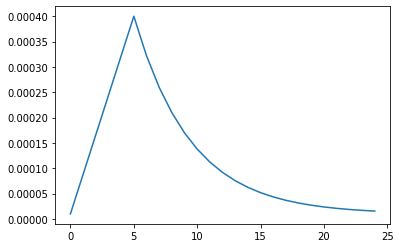

In [15]:
 #Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Cut Mix Augmentation

Basic Idea from [Chris's](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu) kernel . Research paper in [Arxiv](https://arxiv.org/abs/1905.04899)

For the cut mix to work , we need to convert the labels into one hot encoding.

In [16]:
def one_hot_encode(image,label):
    CLASSES=104
    return image,tf.one_hot(label,CLASSES)

In [17]:
# tf.cast(BATCH_SIZE*tf.math.sqrt(1-0.1),tf.int32)

In [18]:
def cutmix_augment(image,label,prob=0.8):  # Change the prob of cutmix here
    DIM=IMAGE_SIZE[0]
    CLASSES=104
    
    imgs=[];labs=[]
    for j in range(AUG_BATCH):
        # Generate the probability:
        P=tf.cast(tf.random.uniform([],0,1)<=prob,tf.int32)
        #Generate a random image:
        K=tf.cast(tf.random.uniform([],0,AUG_BATCH),tf.int32)
        #Generate x,y coordinates:
        x=tf.cast(tf.random.uniform([],0,DIM),tf.int32)
        y=tf.cast(tf.random.uniform([],0,DIM),tf.int32)
        #beta distribution:
        b=tf.random.uniform([],0,1)
        WIDTH=tf.cast(DIM*tf.math.sqrt(1-b),tf.int32)*P
        ya=tf.math.maximum(0,y-WIDTH//2)
        yb=tf.math.minimum(DIM,y+WIDTH//2)
        xa=tf.math.maximum(0,x-WIDTH//2)
        xb=tf.math.minimum(DIM,x+WIDTH//2)
        
        ##Make Cut Mix Image:
        one=image[j,ya:yb,0:xa,:]   #images of size [n,dim,dim,3]
        two=image[K,ya:yb,xa:xb,:]
        three=image[j,ya:yb,xb:DIM,:]
        middle=tf.concat([one,two,three],axis=1)
        img=tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        ## Make the cutmix label:
        a=tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        
        if len(label.shape)==1:
            lab1=tf.one_hot(label[j],CLASSES)
            lab2=tf.one_hot(label[K],CLASSES)
        
        else:
            lab1=label[j,]
            lab2=label[K,]
        labs.append((1-a)*lab1 + a*lab2)
        
        
    image2=tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2=tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2
    
    

## Generalized Mean Pooling

In [19]:
class Generalized_mean_pooling2D(tf.keras.layers.Layer):
    def __init__(self, p=3, epsilon=1e-6, name='', **kwargs):
      super(Generalized_mean_pooling2D, self).__init__(name, **kwargs)
      self.init_p = p
      self.epsilon = epsilon
    
    def build(self, input_shape):
      if isinstance(input_shape, list) or len(input_shape) != 4:
        raise ValueError('`GeM` pooling layer only allow 1 input with 4 dimensions(b, h, w, c)')
      self.build_shape = input_shape
      self.p = self.add_weight(
              name='p',
              shape=[1,],
              initializer=tf.keras.initializers.Constant(value=self.init_p),
              regularizer=None,
              trainable=True,
              dtype=tf.float32
              )
      self.built=True

    def call(self, inputs):
      input_shape = inputs.get_shape()
      if isinstance(inputs, list) or len(input_shape) != 4:
        raise ValueError('`GeM` pooling layer only allow 1 input with 4 dimensions(b, h, w, c)')
      return (tf.reduce_mean(tf.abs(inputs**self.p), axis=[1,2], keepdims=False) + self.epsilon)**(1.0/self.p)


## Check how the augmentation works:

In [20]:
rows=5
cols=5

rows=min(rows,AUG_BATCH//cols)
all_elements=get_training_dataset(load_dataset(TRAINING_FILENAMES),do_cm=False).unbatch()

augmented_elements=all_elements.repeat().batch(AUG_BATCH).map(cutmix_augment)



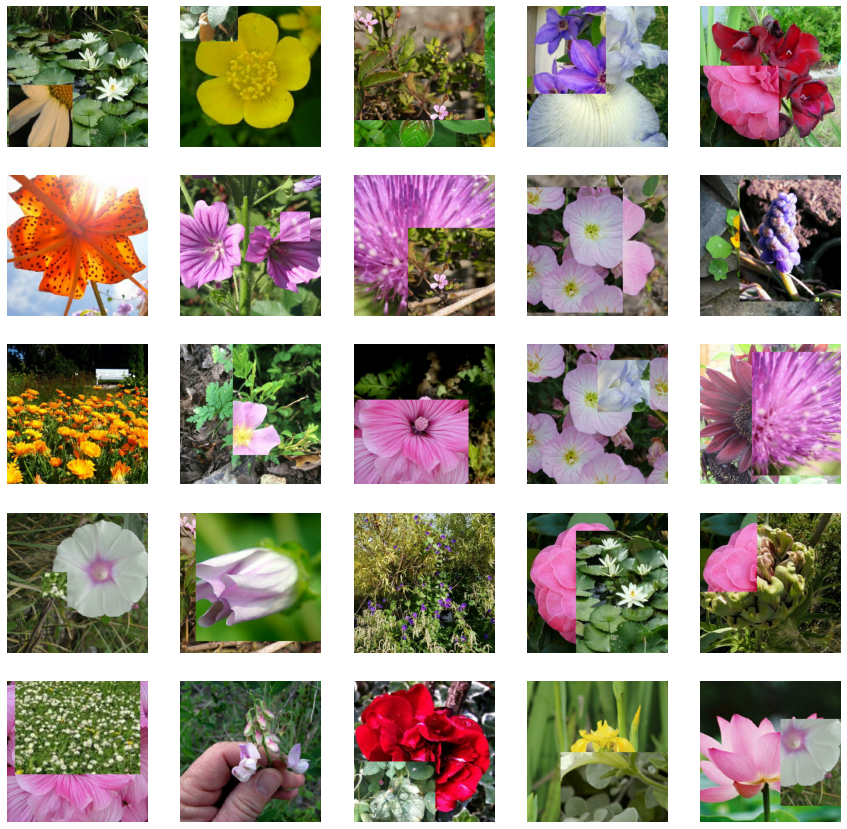

In [21]:
for (img,label) in augmented_elements:
    plt.figure(figsize=(15,int(15*rows/cols)))
    for j in range(rows*cols):
        plt.subplot(rows,cols,j+1)
        plt.axis('off')
        #print(img[j,].numpy().shape)
        plt.imshow(img[j,])
    plt.show()
    break

In [22]:
for (img,label) in augmented_elements.take(3):
    print(img.numpy().shape,label.numpy().shape)

(64, 331, 331, 3) (64, 104)
(64, 331, 331, 3) (64, 104)
(64, 331, 331, 3) (64, 104)


In [23]:
def get_model():

    with strategy.scope():
        pretrained_model=efn.EfficientNetB3(input_shape=(300,300,3),include_top=False,weights="noisy-student")
        #pretrained_model.trainable = False # Removing the pretrained weights since pretrained weights give an categorical accuracy of max 0.34 . 
        model=tf.keras.Sequential([pretrained_model,
                                   Generalized_mean_pooling2D(),
                                   #tf.keras.layers.GlobalAveragePooling2D(),
                                   #tf.keras.layers.GlobalMaxPool2D(),
                                   tf.keras.layers.Dropout(0.3),
                                   tf.keras.layers.Dense(1024,activation='relu'),
                                   #tf.keras.layers.Dropout(0.4),
                                  tf.keras.layers.Dense(len(CLASSES),activation="softmax",dtype='float32')])
        #es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto',patience=5,verbose=1)
        #rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,verbose=1,mode='min',epsilon=0.0001)
    # lr_scheduler=tfa.optimizers.CyclicalLearningRate(initial_learning_rate=5e-5,
    #                                                 maximal_learning_rate=6e-3,
    #                                                 step_size=200,
    #                                                 scale_fn=lambda x:1.,
    #                                                 scale_mode="cycle",
    #                                                 name="cyclic_learning_rate")

    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

In [24]:
def train_model(folds=5):
    histories=[]
    models=[]
    all_preds=[]
    all_probs=[]
    scores=[]
    es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto',patience=5,verbose=1)
    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,verbose=1,mode='min',epsilon=0.0001)
    k_folds=KFold(folds,shuffle=True,random_state=SEED)
    model=get_model()
    for i,(trn_idx,val_idx) in enumerate(k_folds.split(TRAINING_FILENAMES)):
        print(f"---------------Folds {i+1}--------------")
        train_dataset=load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES':TRAINING_FILENAMES}).loc[trn_idx]['TRAINING_FILENAMES']),labeled=True)
        
        valid_dataset=load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES':TRAINING_FILENAMES}).loc[val_idx]['TRAINING_FILENAMES']),labeled=True,ordered=True)
        
        model_checkpoint=tf.keras.callbacks.ModelCheckpoint('model-%i.h5'%(i),
                                                            monitor='val_loss',verbose=1,
                                                            save_best_only=True,save_weights_only=True,save_freq='epoch')
        history= model.fit(get_training_dataset(train_dataset,do_cm=True,do_aug=True), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, validation_data=get_validation_dataset(valid_dataset,do_onehot=True,do_aug=True),callbacks=[es,model_checkpoint,lr_callback])
        NUM_VALID_IMAGES=count_data_items(list(pd.DataFrame({'TRAINING_FILENAMES':TRAINING_FILENAMES}).loc[val_idx]['TRAINING_FILENAMES']))
        cmdataset = get_validation_dataset(valid_dataset,do_onehot=False,do_aug=True)
        images_ds = cmdataset.map(lambda image, label: image)
        labels_ds = cmdataset.map(lambda image, label: label).unbatch()
        cm_correct_labels = next(iter(labels_ds.batch(NUM_VALID_IMAGES))).numpy() # get everything as one batch
        cm_probabilities = model.predict(images_ds)
        cm_predictions = np.argmax(cm_probabilities, axis=-1)

        cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
        score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
        scores.append(score)
        print(f"Macro F1 Score for epoch {i+1}:",score)
#         print(f"---------Loss curve for epoch {i+1}---------")
#         display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
#         print(f'---------Accuracy curve for epoch {i+1}---------')
#         display_training_curves(history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 'accuracy', 212)
        models.append(model)
        histories.append(history)
        
        if FIRST_FOLD_ONLY:break
    print(f'Average F1 score for all epochs:{np.average(scores)}')
    return histories,models

In [25]:
def train_model_predict(folds=5):
    test_dataset=get_test_dataset(ordered=True,do_aug=True)
    test_images_ds=test_dataset.map(lambda image,idnum:image)
    print(f"------Starting Training for Folds {folds}-----")
    histories,models=train_model(folds=folds)
    print(f'-----Computing Prediction---')
     # get the mean probability of the folds models
    if FIRST_FOLD_ONLY: probabilities = np.average([models[i].predict(test_images_ds) for i in range(1)], axis = 0)
    else: probabilities = np.average([models[i].predict(test_images_ds) for i in range(folds)], axis = 0)
    predictions = np.argmax(probabilities, axis=-1)
    print('Generating submission.csv file...')
    test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
    np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
    return histories, models
    

In [26]:
FIRST_FOLD_ONLY = False
FOLDS=5
histories,models=train_model_predict(folds=FOLDS)

------Starting Training for Folds 5-----
43933696/43933088 [==============================] - 2s 0us/step
---------------Folds 1--------------
Train for 199 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
198/199 [============================>.] - ETA: 0s - loss: 4.6328 - categorical_accuracy: 0.0511
Epoch 00001: val_loss improved from inf to 4.17070, saving model to model-0.h5
199/199 [==============================] - 161s 811ms/step - loss: 4.6318 - categorical_accuracy: 0.0509 - val_loss: 4.1707 - val_categorical_accuracy: 0.0627

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/10
198/199 [============================>.] - ETA: 0s - loss: 3.8424 - categorical_accuracy: 0.1850
Epoch 00002: val_loss improved from 4.17070 to 2.43386, saving model to model-0.h5
199/199 [==============================] - 34s 170ms/step - loss: 3.8415 - categorical_accuracy: 0.1853 - val_loss: 2.4339 - val_categorical_accuracy: 0.4612

E

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Macro F1 Score for epoch 3: 0.963199787775753
---------------Folds 4--------------
Train for 199 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
198/199 [============================>.] - ETA: 0s - loss: 1.0647 - categorical_accuracy: 0.7923
Epoch 00001: val_loss improved from inf to 0.01575, saving model to model-3.h5
199/199 [==============================] - 72s 362ms/step - loss: 1.0642 - categorical_accuracy: 0.7915 - val_loss: 0.0157 - val_categorical_accuracy: 1.0000

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/10
198/199 [============================>.] - ETA: 0s - loss: 0.9954 - categorical_accuracy: 0.7917
Epoch 00002: val_loss improved from 0.01575 to 0.01408, saving model to model-3.h5
199/199 [==============================] - 33s 166ms/step - loss: 0.9947 - categorical_accuracy: 0.7915 - val_loss: 0.0141 - val_categorical_accuracy: 1.0000

Epoch 00003: LearningRateScheduler reducing learning rate to 0

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Macro F1 Score for epoch 5: 0.9821679758900613
Average F1 score for all epochs:0.962962187134913
-----Computing Prediction---
Generating submission.csv file...
